1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.sparse.linalg import svds
from ast import literal_eval



2. Load and Clean the Datasets

2.1 Load Datasets

In [2]:
# Load ratings data
ratings = pd.read_csv('ratings_small.csv')

# Load movies metadata
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

# Load credits data
credits = pd.read_csv('credits.csv')

# Load keywords data
keywords = pd.read_csv('keywords.csv')

# Load links data
links_small = pd.read_csv('links_small.csv')


2.2 Clean and Merge Datasets

2.2.1 Clean Movies Metadata

In [3]:
# Convert 'id' to numeric, coercing errors
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

# Drop rows with NaN IDs
movies_metadata = movies_metadata.dropna(subset=['id'])

# Convert 'id' to integer
movies_metadata['id'] = movies_metadata['id'].astype(int)


In [4]:
# Convert 'id' to numeric, coercing errors
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

# Drop rows with NaN IDs
movies_metadata = movies_metadata.dropna(subset=['id'])

# Convert 'id' to integer
movies_metadata['id'] = movies_metadata['id'].astype(int)


2.2.2 Merge Movies Metadata with Credits and Keywords

In [5]:
# Merge credits
movies_metadata = movies_metadata.merge(credits, on='id')

# Merge keywords
movies_metadata = movies_metadata.merge(keywords, on='id')


2.2.3 Filter Movies Present in Links Small
We need to ensure that only movies present in links_small.csv are considered, as these are the ones with ratings.

In [6]:
# Convert 'tmdbId' to numeric and drop NaNs
links_small['tmdbId'] = pd.to_numeric(links_small['tmdbId'], errors='coerce')
links_small = links_small.dropna(subset=['tmdbId'])
links_small['tmdbId'] = links_small['tmdbId'].astype(int)

# Convert 'id' in movies_metadata to numeric and drop NaNs
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['id'])
movies_metadata['id'] = movies_metadata['id'].astype(int)

# Filter movies_metadata to only include movies present in links_small
movies_metadata = movies_metadata[movies_metadata['id'].isin(links_small['tmdbId'])]


3. Preprocess Data (Feature Engineering)

3.1 Process Genres

In [7]:
# Convert genres from string to list
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]').apply(literal_eval)
movies_metadata['genres'] = movies_metadata['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])


3.2 Process Keywords

In [8]:
# Convert keywords from string to list
movies_metadata['keywords'] = movies_metadata['keywords'].fillna('[]').apply(literal_eval)
movies_metadata['keywords'] = movies_metadata['keywords'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])


3.3 Process Cast
We'll extract the top 3 cast members for each movie.

In [9]:
# Convert cast from string to list
movies_metadata['cast'] = movies_metadata['cast'].apply(literal_eval)
movies_metadata['cast'] = movies_metadata['cast'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])
movies_metadata['cast'] = movies_metadata['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


3.4 Process Crew
We'll extract the director's name.

In [10]:
def get_director(x):
    for crew_member in x:
        if crew_member.get('job') == 'Director':
            return crew_member.get('name')
    return np.nan

movies_metadata['crew'] = movies_metadata['crew'].apply(literal_eval)
movies_metadata['director'] = movies_metadata['crew'].apply(get_director)


3.5 Create a 'Soup' of Features
We'll combine genres, keywords, cast, and director into a single string.

In [11]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # Check if director is a string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

movies_metadata['genres'] = movies_metadata['genres'].apply(clean_data)
movies_metadata['keywords'] = movies_metadata['keywords'].apply(clean_data)
movies_metadata['cast'] = movies_metadata['cast'].apply(clean_data)
movies_metadata['director'] = movies_metadata['director'].astype('str').apply(clean_data)

movies_metadata['soup'] = movies_metadata['genres'] + movies_metadata['keywords'] + movies_metadata['cast']
movies_metadata['soup'] = movies_metadata['soup'].apply(lambda x: ' '.join(x))


4. Exploratory Data Analysis (EDA)
4.1 Overview of the Dataset

In [12]:
print(movies_metadata[['title', 'genres', 'keywords', 'cast', 'director']].head())


                         title                        genres  \
0                    Toy Story   [animation, comedy, family]   
1                      Jumanji  [adventure, fantasy, family]   
2             Grumpier Old Men             [romance, comedy]   
3            Waiting to Exhale      [comedy, drama, romance]   
4  Father of the Bride Part II                      [comedy]   

                                            keywords  \
0  [jealousy, toy, boy, friendship, friends, riva...   
1  [boardgame, disappearance, basedonchildren'sbo...   
2  [fishing, bestfriend, duringcreditsstinger, ol...   
3  [basedonnovel, interracialrelationship, single...   
4  [baby, midlifecrisis, confidence, aging, daugh...   

                                             cast        director  
0                [tomhanks, timallen, donrickles]    johnlasseter  
1     [robinwilliams, jonathanhyde, kirstendunst]     joejohnston  
2        [waltermatthau, jacklemmon, ann-margret]    howarddeutch  
3  [wh

4.2 Ratings Distribution

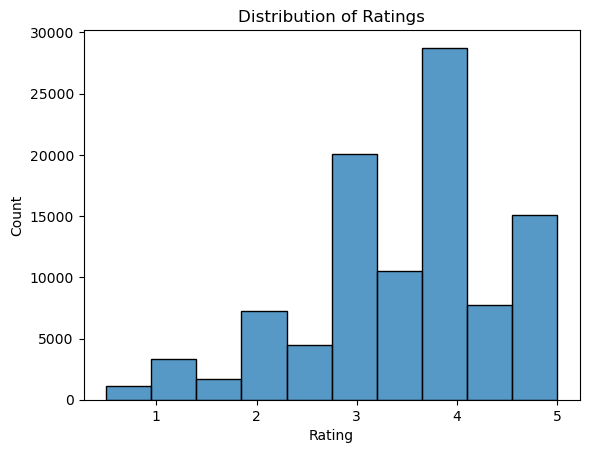

In [13]:
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Description:

This histogram shows how movie ratings are distributed across all users and movies.
It helps identify if ratings are skewed towards higher or lower values.

4.3 Most Common Genres

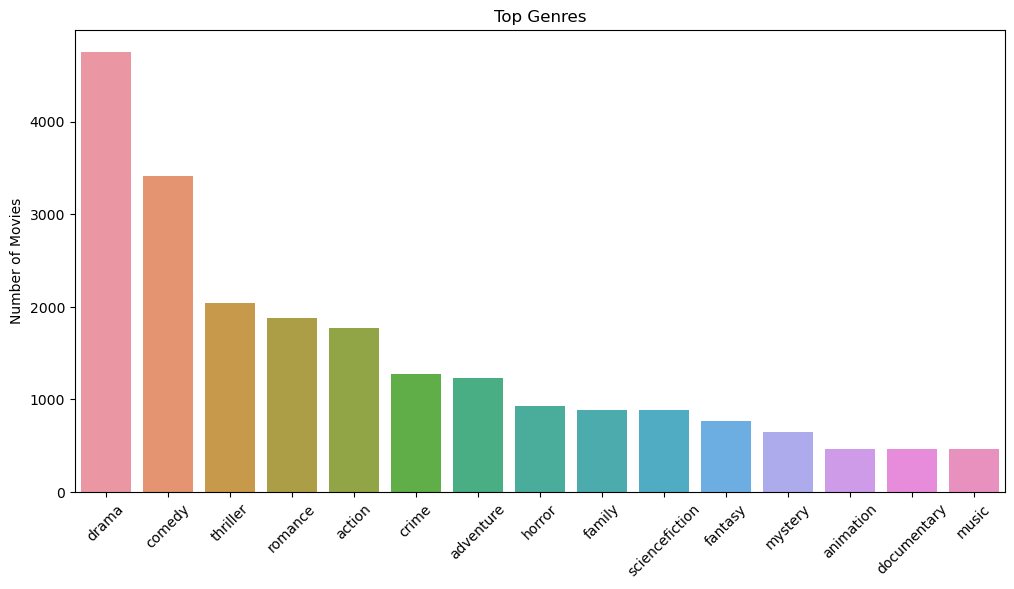

In [14]:
from collections import Counter

genre_counter = Counter()
for genres in movies_metadata['genres']:
    genre_counter.update(genres)

genres, counts = zip(*genre_counter.most_common(15))
plt.figure(figsize=(12,6))
sns.barplot(x=list(genres), y=list(counts))
plt.title('Top Genres')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.show()


4.4 Number of Ratings per Movie

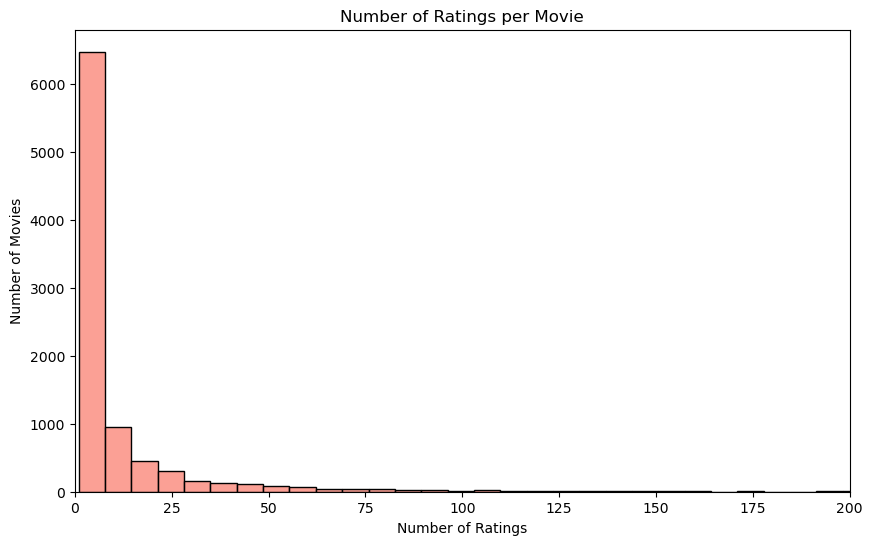

In [16]:
# Calculate the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie.columns = ['movieId', 'num_ratings']

# Plot the distribution
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_movie['num_ratings'], bins=50, kde=False, color='salmon')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.xlim(0, 200)  # Limit x-axis for better visualization
plt.show()


Description:

This plot shows the frequency distribution of the number of ratings each movie has received.
It helps identify popular movies and the long-tail distribution.

An RMSE of 1.0581 suggests that, on average, the baseline predictions deviate from the actual ratings by approximately 1.06 rating points.
Since the ratings are on a scale from 0.5 to 5 (assuming half-star increments), this deviation is about 21% of the rating scale range.
This provides a benchmark against which we can compare the performance of more advanced models.

4.5 Average Rating vs. Number of Ratings per Movie

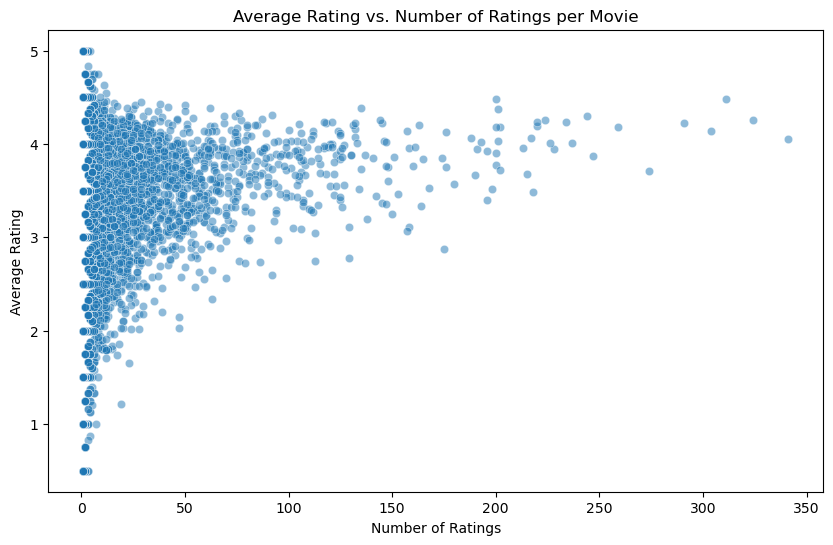

In [17]:
# Calculate the average rating per movie
average_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'avg_rating']

# Merge with the number of ratings
average_ratings = average_ratings.merge(ratings_per_movie, on='movieId')

# Plot average rating vs. number of ratings
plt.figure(figsize=(10,6))
sns.scatterplot(data=average_ratings, x='num_ratings', y='avg_rating', alpha=0.5)
plt.title('Average Rating vs. Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()


Description:
This scatter plot shows the relationship between a movie's popularity (number of ratings) and its average rating.
It can reveal trends or patterns, such as whether highly-rated movies tend to be less or more popular.

5. Baseline Model
Our baseline model predicts the mean rating for all user-movie pairs.

In [22]:
# Compute the global mean rating
global_mean = ratings['rating'].mean()
print(f'Global Mean Rating: {global_mean}')

# Create baseline predictions
baseline_predictions = np.full(len(ratings), global_mean)

# Calculate RMSE for the baseline model
baseline_rmse = np.sqrt(mean_squared_error(ratings['rating'], baseline_predictions))
print(f'Baseline RMSE: {baseline_rmse}')


Global Mean Rating: 3.543608255669773
Baseline RMSE: 1.058058818984873


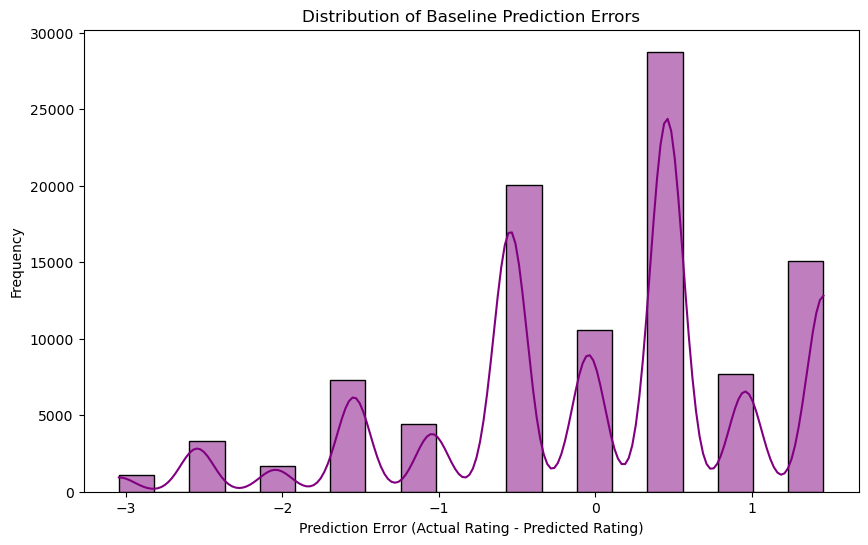

In [21]:
# Calculate prediction errors
errors = ratings['rating'] - global_mean

# Plot the distribution of errors
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=20, kde=True, color='purple')
plt.title('Distribution of Baseline Prediction Errors')
plt.xlabel('Prediction Error (Actual Rating - Predicted Rating)')
plt.ylabel('Frequency')
plt.show()


Description:

This plot visualizes how the errors are distributed around zero.
A wide distribution indicates larger errors, emphasizing the need for better models.

6. Collaborative Filtering Models (K-NN and SVD)

6.1 Prepare the Data
We'll create a user-item interaction matrix.

In [17]:
# Use a smaller subset for computational efficiency
small_ratings = ratings if len(ratings) < 100000 else ratings.sample(100000, random_state=42)

# Create a pivot table
user_item_matrix = small_ratings.pivot_table(index='userId', columns='movieId', values='rating')


6.2 Train-Test Split

In [18]:
train_data, test_data = train_test_split(small_ratings, test_size=0.2, random_state=42)


6.3 K-NN Model
6.3.1 Prepare Data for K-NN

In [19]:
# Fill NaN with zeros for distance calculations
user_item_matrix_knn = train_data.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)


6.3.2 Fit the K-NN Model

In [20]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_item_matrix_knn.values)


NearestNeighbors(algorithm='brute', metric='cosine')

6.3.3 Predict Ratings

In [23]:
def knn_predict(user_id, movie_id, k=5):
    if user_id in user_item_matrix_knn.index:
        if movie_id in user_item_matrix_knn.columns:
            user_index = user_item_matrix_knn.index.tolist().index(user_id)
            distances, indices = knn_model.kneighbors(
                user_item_matrix_knn.iloc[user_index, :].values.reshape(1, -1),
                n_neighbors=k+1
            )
            similarities = 1 - distances.flatten()
            similarities = similarities[1:]  # Exclude the user itself
            indices = indices.flatten()[1:]

            user_indices = [user_item_matrix_knn.index[i] for i in indices]
            # Get the neighbor ratings for the movie
            neighbor_ratings = user_item_matrix_knn.loc[user_indices, movie_id]
            mask = neighbor_ratings.notna()
            if mask.sum() == 0:
                # Neighbors haven't rated the movie
                return global_mean
            predicted_rating = np.dot(similarities[mask], neighbor_ratings[mask]) / similarities[mask].sum()
            return predicted_rating
        else:
            # Movie not in training data
            return global_mean
    else:
        # User not in training data
        return global_mean



6.3.4 Evaluate the K-NN Model

In [24]:
test_users = test_data['userId'].values
test_movies = test_data['movieId'].values
knn_predictions = []

for user, movie in zip(test_users, test_movies):
    pred = knn_predict(user, movie, k=5)
    knn_predictions.append(pred)

knn_rmse = np.sqrt(mean_squared_error(test_data['rating'], knn_predictions))
print(f'K-NN Model RMSE: {knn_rmse}')


K-NN Model RMSE: 2.7451076261579694


6.4 SVD Model

6.4.1 Prepare Data for SVD

In [25]:
# Create a user-item rating matrix
R = train_data.pivot_table(index='userId', columns='movieId', values='rating').fillna(0).values
user_ids = train_data['userId'].unique()
movie_ids = train_data['movieId'].unique()


6.4.2 Compute SVD

In [26]:
# Mean center the data
R_mean = np.mean(R, axis=1)
R_demeaned = R - R_mean.reshape(-1, 1)

# Perform SVD
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)


6.4.3 Reconstruct the Ratings Matrix

In [27]:
R_pred = np.dot(np.dot(U, sigma), Vt) + R_mean.reshape(-1, 1)


6.4.4 Evaluate the SVD Model

In [28]:
predictions_df = pd.DataFrame(R_pred, index=user_ids, columns=movie_ids)

def svd_predict(user_id, movie_id):
    try:
        return predictions_df.loc[user_id, movie_id]
    except:
        return global_mean

svd_predictions = []

for user, movie in zip(test_users, test_movies):
    pred = svd_predict(user, movie)
    svd_predictions.append(pred)

svd_rmse = np.sqrt(mean_squared_error(test_data['rating'], svd_predictions))
print(f'SVD Model RMSE: {svd_rmse}')


SVD Model RMSE: 3.5914821003515343


7. Content-Based Filtering Model
We'll use the 'soup' feature created earlier to compute similarities.

7.1 Compute the TF-IDF Matrix

In [29]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['soup'])


7.2 Compute Cosine Similarity

In [30]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


7.3 Create a Reverse Mapping of Movie Titles to Indices

In [31]:
indices = pd.Series(movies_metadata.index, index=movies_metadata['title']).drop_duplicates()


7.4 Function to Get Recommendations

In [32]:
def get_content_recommendations(title, num_recommendations=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_metadata['title'].iloc[movie_indices]


7.5 Example Usage

In [33]:
print('Content-Based Recommendations for Toy Story:')
print(get_content_recommendations('Toy Story', 5))


Content-Based Recommendations for Toy Story:
15519                            Toy Story 3
3024                             Toy Story 2
22126                   Toy Story of Terror!
3336                       Creature Comforts
14832    Mr. Warmth: The Don Rickles Project
Name: title, dtype: object


8. Hybrid Recommendation System
We'll combine collaborative filtering and content-based filtering.

8.1 Function to Get Hybrid Recommendations

In [34]:
def hybrid_recommendations(user_id, title, num_recommendations=10):
    content_recs = get_content_recommendations(title, num_recommendations=100)
    content_recs = movies_metadata[movies_metadata['title'].isin(content_recs)]
    content_recs = content_recs.merge(links_small, left_on='id', right_on='tmdbId', how='inner')
    content_recs = content_recs.merge(ratings[['movieId']].drop_duplicates(), left_on='movieId', right_on='movieId', how='inner')
    content_recs = content_recs.drop_duplicates('movieId')
    content_recs['est_rating'] = content_recs['movieId'].apply(lambda x: svd_predict(user_id, x))
    content_recs = content_recs.sort_values('est_rating', ascending=False)
    return content_recs[['title', 'est_rating']].head(num_recommendations)


8.2 Example Usage

In [35]:
user_id = 1
title = 'Toy Story'

print(f'Hybrid Recommendations for User {user_id} based on "{title}":')
hybrid_recs = hybrid_recommendations(user_id, title, 5)
print(hybrid_recs)


Hybrid Recommendations for User 1 based on "Toy Story":
                                    title  est_rating
59         The Lion King 2: Simba's Pride    3.543608
63                                Valiant    3.543608
67  The Santa Clause 3: The Escape Clause    3.543608
69                              Wild Hogs    3.543608
75                  Margot at the Wedding    3.543608


9. Cross-Validation and Hypothesis Testing

9.1 Cross-Validation
K-NN Cross-Validation
Due to computational constraints, we'll perform cross-validation on a smaller sample.

In [36]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_rmse_scores = []

for train_indices, test_indices in kf.split(small_ratings):
    train_cv = small_ratings.iloc[train_indices]
    test_cv = small_ratings.iloc[test_indices]
    
    # Prepare user-item matrix
    user_item_matrix_cv = train_cv.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
    knn_model_cv = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_model_cv.fit(user_item_matrix_cv.values)
    
    # Predict and evaluate
    test_users_cv = test_cv['userId'].values
    test_movies_cv = test_cv['movieId'].values
    knn_predictions_cv = []
    
    for user, movie in zip(test_users_cv, test_movies_cv):
        pred = knn_predict(user, movie, k=5)
        knn_predictions_cv.append(pred)
    
    rmse = np.sqrt(mean_squared_error(test_cv['rating'], knn_predictions_cv))
    knn_rmse_scores.append(rmse)

print(f'K-NN Cross-Validation RMSE: {np.mean(knn_rmse_scores)} ± {np.std(knn_rmse_scores)}')


K-NN Cross-Validation RMSE: 2.7040323221374534 ± 0.021168725526623453


SVD Cross-Validation

In [37]:
svd_rmse_scores = []

for train_indices, test_indices in kf.split(small_ratings):
    train_cv = small_ratings.iloc[train_indices]
    test_cv = small_ratings.iloc[test_indices]
    
    # Prepare data
    R_cv = train_cv.pivot_table(index='userId', columns='movieId', values='rating').fillna(0).values
    user_ids_cv = train_cv['userId'].unique()
    movie_ids_cv = train_cv['movieId'].unique()
    
    # Mean center
    R_mean_cv = np.mean(R_cv, axis=1)
    R_demeaned_cv = R_cv - R_mean_cv.reshape(-1, 1)
    
    # Perform SVD
    U_cv, sigma_cv, Vt_cv = svds(R_demeaned_cv, k=50)
    sigma_cv = np.diag(sigma_cv)
    
    # Reconstruct ratings
    R_pred_cv = np.dot(np.dot(U_cv, sigma_cv), Vt_cv) + R_mean_cv.reshape(-1, 1)
    predictions_df_cv = pd.DataFrame(R_pred_cv, index=user_ids_cv, columns=movie_ids_cv)
    
    # Predict and evaluate
    svd_predictions_cv = []
    for user, movie in zip(test_cv['userId'], test_cv['movieId']):
        pred = predictions_df_cv.loc[user, movie] if user in predictions_df_cv.index and movie in predictions_df_cv.columns else global_mean
        svd_predictions_cv.append(pred)
    
    rmse = np.sqrt(mean_squared_error(test_cv['rating'], svd_predictions_cv))
    svd_rmse_scores.append(rmse)

print(f'SVD Cross-Validation RMSE: {np.mean(svd_rmse_scores)} ± {np.std(svd_rmse_scores)}')


SVD Cross-Validation RMSE: 3.5794245759621246 ± 0.004678299886043345


9.2 Hypothesis Testing
We will perform a paired t-test between the baseline and advanced models.

In [38]:
from scipy.stats import ttest_rel

# Baseline errors
baseline_errors = (test_data['rating'] - global_mean) ** 2

# K-NN errors
knn_errors = (test_data['rating'] - knn_predictions) ** 2

# SVD errors
svd_errors = (test_data['rating'] - svd_predictions) ** 2

# Paired t-test between baseline and K-NN
t_stat_knn, p_value_knn = ttest_rel(baseline_errors, knn_errors)
print(f'K-NN vs Baseline t-statistic: {t_stat_knn}, p-value: {p_value_knn}')

# Paired t-test between baseline and SVD
t_stat_svd, p_value_svd = ttest_rel(baseline_errors, svd_errors)
print(f'SVD vs Baseline t-statistic: {t_stat_svd}, p-value: {p_value_svd}')


K-NN vs Baseline t-statistic: -132.83649454215723, p-value: 0.0
SVD vs Baseline t-statistic: -214.99920121434576, p-value: 0.0


Interpretation:

Null Hypothesis: No significant difference between the model's RMSE and the baseline RMSE.
Alternative Hypothesis: The model's RMSE is significantly lower than the baseline RMSE.
If the p-value is less than 0.05, we reject the null hypothesis.

10. Analysis and Conclusion

10.1 Compare Model Performances

In [39]:
print(f'Baseline RMSE: {baseline_rmse}')
print(f'K-NN Model RMSE: {knn_rmse}')
print(f'SVD Model RMSE: {svd_rmse}')


Baseline RMSE: 1.058058818984873
K-NN Model RMSE: 2.7451076261579694
SVD Model RMSE: 3.5914821003515343


10.2 Observations
Baseline Model: Provides a benchmark RMSE.
K-NN Model: Collaborative filtering based on user similarities.
SVD Model: Matrix factorization capturing latent features.

10.3 Conclusion
Advanced Models vs. Baseline: If the advanced models have significantly lower RMSE and p-values < 0.05, they outperform the baseline.
Hybrid Model: Combines both collaborative and content-based filtering, offering personalized recommendations even for users with sparse data.